# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе. 

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.




## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



Импорт базовых библиотек:

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import re
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [47]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [48]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [49]:
# Удаление строк с пропусками в CustomerID 
cleaned_data = data.dropna(subset=['CustomerID'])

#### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалите их из данных.


In [50]:
# Проверка на наличие дубликатов
duplicates = cleaned_data.duplicated()

# Вывод количества дубликатов
print(f'Количество дубликатов: {duplicates.sum()}')

# Удаление дубликатов
data = cleaned_data.drop_duplicates()

Количество дубликатов: 5225


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [51]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

*Осторожно! Поиск отменённых транзакций занимает много времени из-за большого количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от мощности компьютера.*

In [52]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

*Осторожно! Поиск отмененных транзакций занимает достаточно длительное время из-за количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от компьютера.*

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.



In [53]:
# 1. Поиск транзакций без контрагентов
transactions_without_customer = data[data['CustomerID'].isnull()]
count_without_customer = transactions_without_customer.shape[0]

print(transactions_without_customer)
print(count_without_customer)

# 2. Удаление транзакций без контрагентов, если их количество невелико
if count_without_customer < 0.05 * data.shape[0]:  # например, меньше 5%
    data = data[data['CustomerID'].notnull()]
    
# 3. Удаление транзакций с отрицательным количеством товара
data = data[data['Quantity'] >= 0]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, QuantityCanceled]
Index: []
0


#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [54]:
# 1. Найти специальные виды транзакций
special_transactions = data[data['StockCode'].str.match(r'^[a-zA-Z]+')]

# 2. Удалить специальные транзакции из данных
data = data[~data['StockCode'].str.match(r'^[a-zA-Z]+')]


print(special_transactions[['StockCode', 'Description']])

       StockCode Description
45          POST     POSTAGE
386         POST     POSTAGE
1123        POST     POSTAGE
1423          C2    CARRIAGE
2239           M      Manual
...          ...         ...
541198      POST     POSTAGE
541216      POST     POSTAGE
541730      POST     POSTAGE
541767      POST     POSTAGE
541768      POST     POSTAGE

[1549 rows x 2 columns]


#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [55]:
# 1. Подсчет транзакций с ценой в 0 фунтов стерлингов
zero_price_transactions = data[data['UnitPrice'] == 0]
count_zero_price = zero_price_transactions.shape[0]

# 2. Проверка, составляет ли количество транзакций с нулевой ценой менее 1%
if count_zero_price < 0.01 * data.shape[0]:  # менее 1%
    # 3. Удаление транзакций с нулевой ценой
    data = data[data['UnitPrice'] > 0]

print(data.shape[0])

391150


#### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [56]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
print(data[['UnitPrice', 'Quantity', 'QuantityCanceled', 'TotalPrice']].head())


   UnitPrice  Quantity  QuantityCanceled  TotalPrice
0       2.55         6               0.0       15.30
1       3.39         6               0.0       20.34
2       2.75         8               0.0       22.00
3       3.39         6               0.0       20.34
4       3.39         6               0.0       20.34


Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



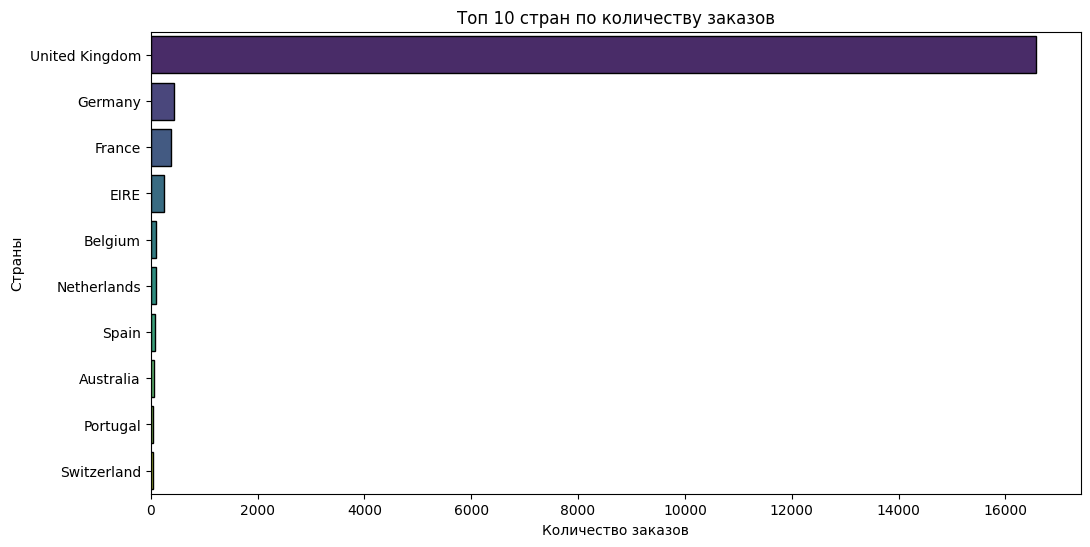

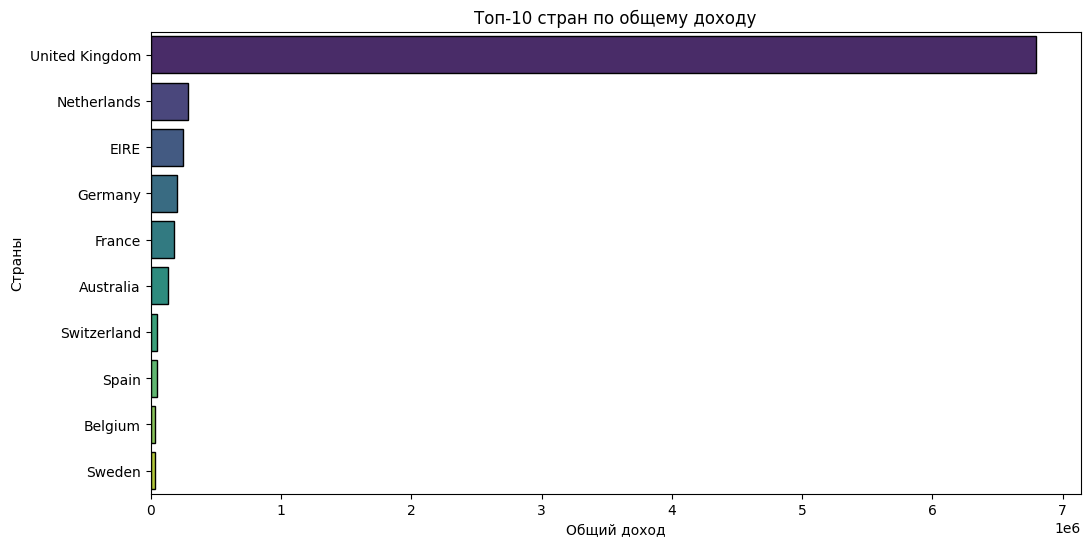

In [57]:
country_sales = data.groupby('Country').agg({'InvoiceNo': 'nunique', 'TotalPrice': 'sum'}).reset_index()
country_sales.columns = ['Country', 'Number_of_Orders', 'Total_Revenue']

# Сортировка по количеству заказов
top_countries_by_orders = country_sales.sort_values(by='Number_of_Orders', ascending=False)
top_countries_by_revenue = country_sales.sort_values(by='Total_Revenue', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x='Number_of_Orders', y='Country', data=top_countries_by_orders.head(10), palette='viridis')
plt.title('Топ 10 стран по количеству заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Страны')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Revenue', y='Country', data=top_countries_by_revenue.head(10), palette='viridis')
plt.title('Топ-10 стран по общему доходу')
plt.xlabel('Общий доход')
plt.ylabel('Страны')
plt.show()

In [58]:
# Преобразование столбца InvoiceDate в формат datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Проверка преобразования
print(data['InvoiceDate'].head())

# Создание дополнительных столбцов для анализа
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Hour'] = data['InvoiceDate'].dt.hour
data['Day'] = data['InvoiceDate'].dt.date

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


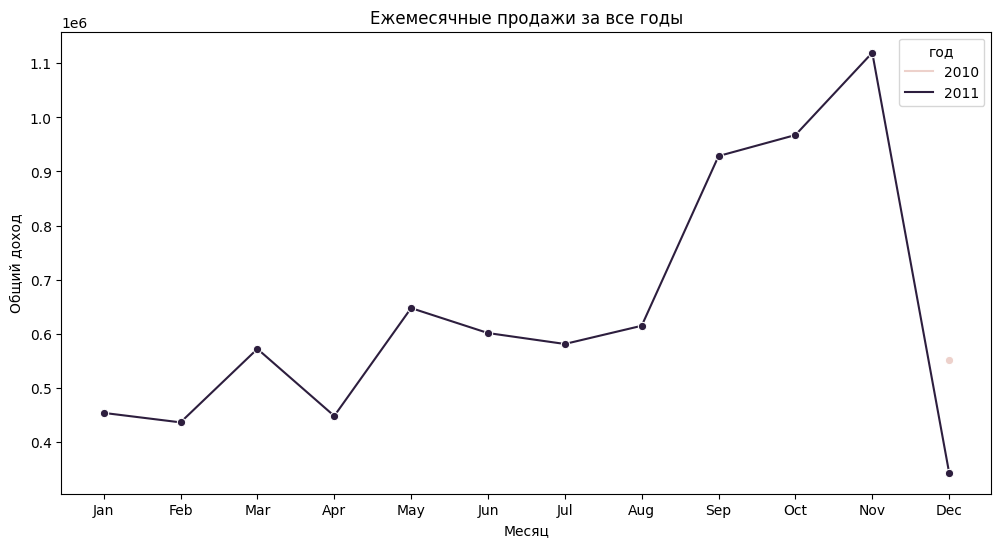

In [59]:
monthly_sales = data.groupby(['Year', 'Month']).agg({'TotalPrice': 'sum'}).reset_index()

# Визуализация
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='TotalPrice', hue='Year', marker='o')
plt.title('Ежемесячные продажи за все годы')
plt.xlabel('Месяц')
plt.ylabel('Общий доход')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='год')
plt.show()

In [60]:
seasonal_revenue = data.groupby(['Year', 'Month', 'Country']).agg({'TotalPrice': 'sum'}).reset_index()



# Визуализация
fig = px.line(
    seasonal_revenue,
    x='Month',
    y='TotalPrice',
    color='Country',
    markers=True,
    title='Сезонный доход по странам',
    labels={'Month': 'Месяц', 'TotalPrice': 'Общий доход'},
    template='plotly_white'
)

fig.update_layout(
    xaxis=dict(tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']),
    hovermode='x unified'  # Показывает данные при наведении
)

fig.show()

United Kingdom Страна на самом верху. В таблице справа, можно отлючить и посмотреть на другие страны.

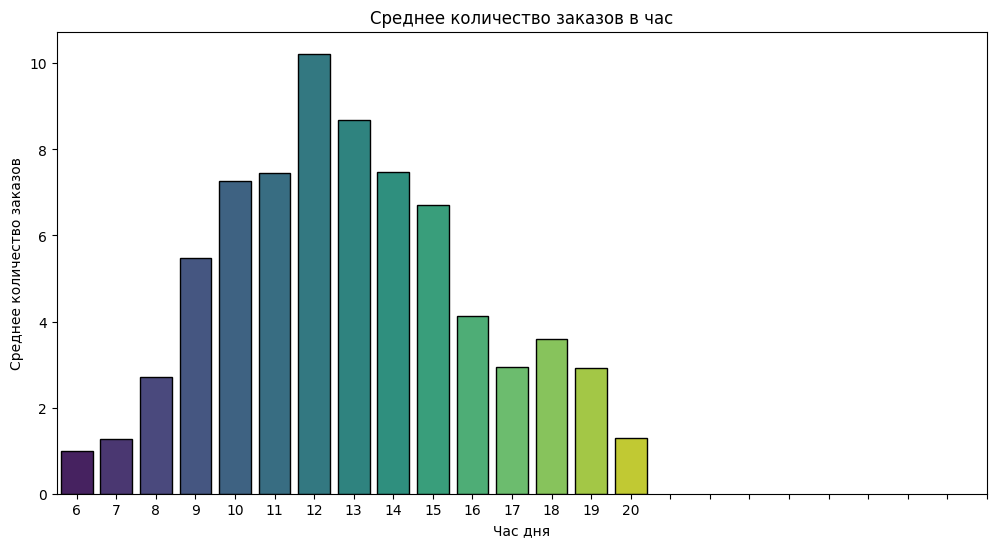

In [61]:
daily_hourly_orders = data.groupby(['Day', 'Hour']).agg({'InvoiceNo': 'nunique'}).reset_index()
daily_hourly_orders.columns = ['Day', 'Hour', 'Number_of_Orders']

# Среднее количество ежедневно поступающих заказов в каждый час
average_orders_per_hour = daily_hourly_orders.groupby('Hour')['Number_of_Orders'].mean().reset_index()

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='Number_of_Orders', data=average_orders_per_hour, palette='viridis')
plt.title('Среднее количество заказов в час')
plt.xlabel('Час дня')
plt.ylabel('Среднее количество заказов')
plt.xticks(ticks=np.arange(0, 24))
plt.show()

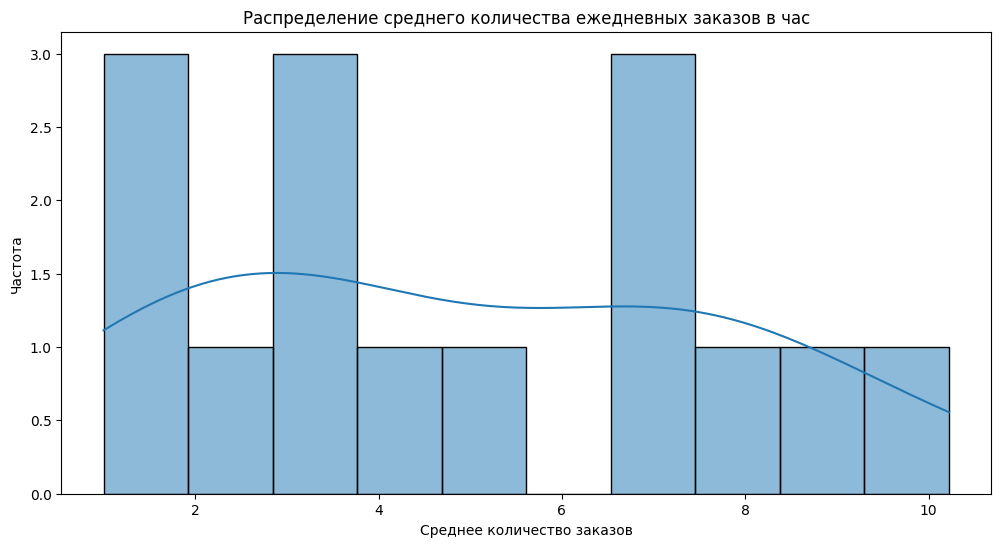

In [62]:
# Визуализация распределения
plt.figure(figsize=(12, 6))
sns.histplot(average_orders_per_hour['Number_of_Orders'], bins=10, kde=True)
plt.title('Распределение среднего количества ежедневных заказов в час')
plt.xlabel('Среднее количество заказов')
plt.ylabel('Частота')
plt.show()

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [63]:
# 1. Установка точки отсчета (на день позже последней даты в данных)
reference_date = pd.to_datetime('2011-12-10 00:00:00')

# 2. Предварительная обработка (если нужно)
# Удаление возвратов (если они помечены отрицательными суммами)
data = data[data['TotalPrice'] > 0]

# 3. Расчет RFM-метрик
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (уникальные заказы)
    'TotalPrice': 'sum'      # Monetary Value
}).reset_index()

# 4. Переименование столбцов
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# 5. Пример результата
print(rfm.head())



  CustomerID  Recency  Frequency  Monetary
0      12347        2          7   4310.00
1      12348       75          4   1437.24
2      12349       18          1   1457.55
3      12350      310          1    294.40
4      12352       36          6   1265.41


После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot). Вы получите примерно следующие результаты (графики могут отличаться в зависимости от того, как вы выполните предобработку данных):

In [64]:
# Преобразуем данные в "длинный" формат для Plotly Express
rfm_melted = rfm.melt(id_vars=['CustomerID'], 
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric', 
                      value_name='Value')

# Строим boxplot
fig = px.box(rfm_melted, x='Metric', y='Value', 
             title="Распределение RFM-метрик",
             color='Metric',
             width=800, height=500)

fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [65]:
# Рассчитываем 95% квантили для Frequency и Monetary
freq_threshold = rfm['Frequency'].quantile(0.95)
monetary_threshold = rfm['Monetary'].quantile(0.95)

print(f"95% квантиль для Frequency: {freq_threshold}")
print(f"95% квантиль для Monetary: {monetary_threshold}")

95% квантиль для Frequency: 13.0
95% квантиль для Monetary: 5662.711999999997


In [66]:
# Создаем отфильтрованный датафрейм
rfm_filtered = rfm[
    (rfm['Frequency'] <= freq_threshold) & 
    (rfm['Monetary'] <= monetary_threshold)
].copy()

# Сравним размеры до и после фильтрации
print(f"Исходный размер: {rfm.shape}")
print(f"После фильтрации: {rfm_filtered.shape}")
print(f"Удалено записей: {len(rfm) - len(rfm_filtered)} ({(len(rfm) - len(rfm_filtered))/len(rfm)*100:.1f}%)")

Исходный размер: (4324, 4)
После фильтрации: (4035, 4)
Удалено записей: 289 (6.7%)


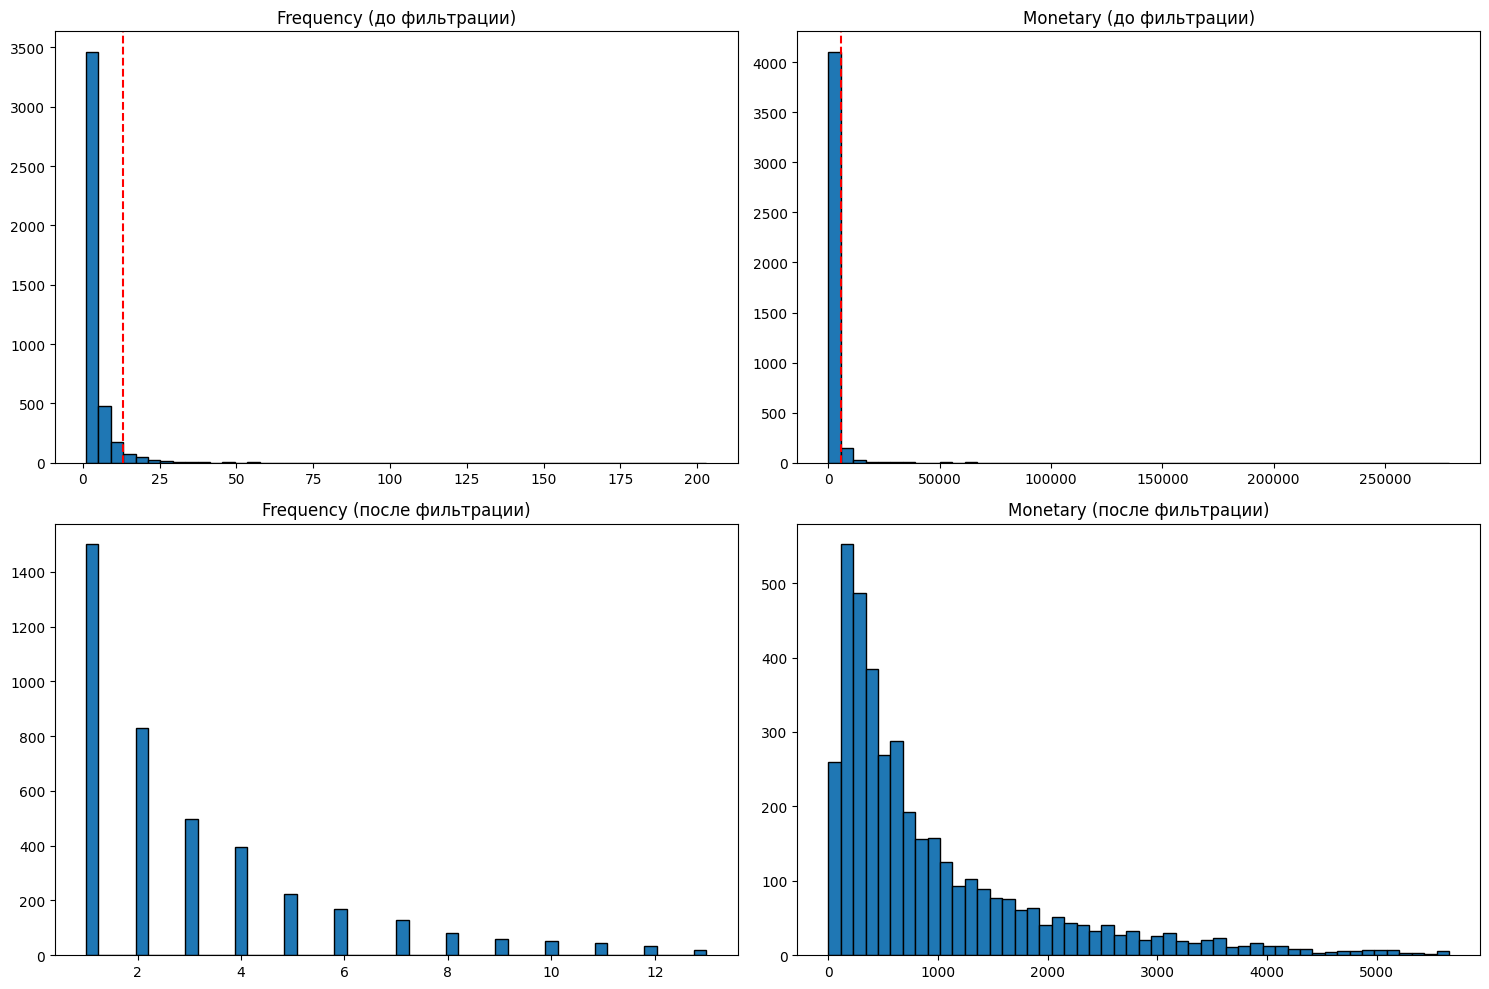

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# До фильтрации
axes[0,0].hist(rfm['Frequency'], bins=50)
axes[0,0].set_title('Frequency (до фильтрации)')
axes[0,0].axvline(freq_threshold, color='r', linestyle='--')

axes[0,1].hist(rfm['Monetary'], bins=50)
axes[0,1].set_title('Monetary (до фильтрации)')
axes[0,1].axvline(monetary_threshold, color='r', linestyle='--')

# После фильтрации
axes[1,0].hist(rfm_filtered['Frequency'], bins=50)
axes[1,0].set_title('Frequency (после фильтрации)')

axes[1,1].hist(rfm_filtered['Monetary'], bins=50)
axes[1,1].set_title('Monetary (после фильтрации)')

plt.tight_layout()
plt.show()

## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


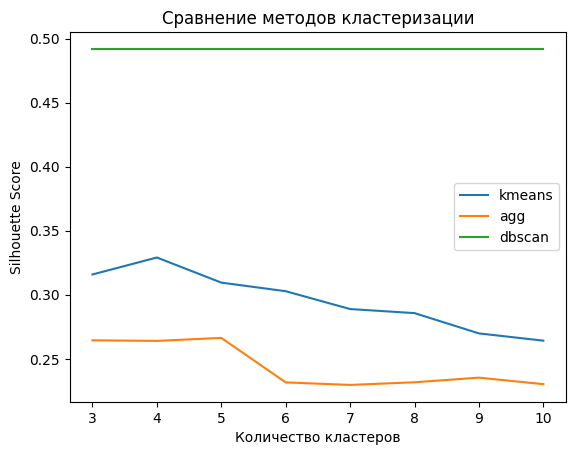

Лучший метод: kmeans с 4 кластерами (score=0.329)


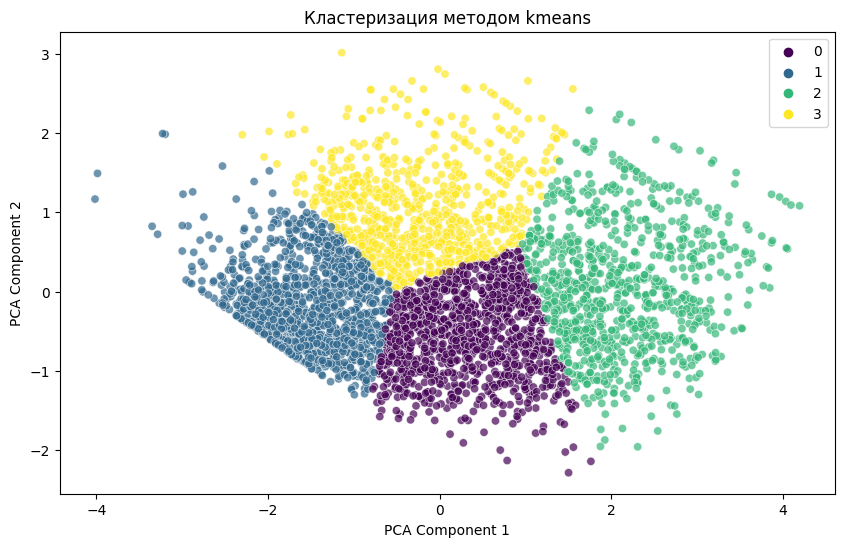


Статистика по кластерам:
        Recency        Frequency       Monetary          CustomerID
           mean    std      mean   std     mean      std      count
Cluster                                                            
0         94.81  68.73      3.14  1.32  1162.85   723.93       1094
1        198.02  99.03      1.17  0.42   286.52   191.91       1300
2         17.44  17.25      6.66  2.59  2282.98  1149.68        878
3         22.76  14.91      1.72  0.79   393.66   233.64        763


In [68]:
# 1. Предобработка данных
def preprocess_data(rfm):
    # Логарифмирование для уменьшения skewness
    rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log1p)
    
    # Стандартизация
    scaler = StandardScaler()
    return scaler.fit_transform(rfm_log)

# 2. Pipeline для кластеризации с понижением размерности
def create_clustering_pipeline(n_clusters, method='kmeans'):
    pipeline_steps = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),  # Понижение до 2D для визуализации
    ]
    
    if method == 'kmeans':
        pipeline_steps.append(('cluster', KMeans(n_clusters=n_clusters, random_state=42)))
    elif method == 'agg':
        pipeline_steps.append(('cluster', AgglomerativeClustering(n_clusters=n_clusters)))
    elif method == 'dbscan':
        pipeline_steps.append(('cluster', DBSCAN(eps=0.5, min_samples=5)))
    
    return Pipeline(pipeline_steps)

# 3. Подбор оптимального числа кластеров
def find_optimal_clusters(data, methods):
    results = {}
    
    for method in methods:
        silhouette_scores = []
        
        for n_clusters in range(3, 11):
            if method == 'dbscan':  # DBSCAN не требует указания n_clusters
                pipeline = create_clustering_pipeline(0, method)
                labels = pipeline.fit_predict(data)
                if len(set(labels)) < 2:  # Недостаточно кластеров
                    silhouette_scores.append(-1)
                    continue
            else:
                pipeline = create_clustering_pipeline(n_clusters, method)
                labels = pipeline.fit_predict(data)
            
            score = silhouette_score(data, labels)
            silhouette_scores.append(score)
        
        results[method] = silhouette_scores
    
    return results

# 4. Визуализация результатов
def plot_clusters(data_2d, labels, method_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data_2d[:,0], y=data_2d[:,1], hue=labels, 
                    palette='viridis', alpha=0.7)
    plt.title(f'Кластеризация методом {method_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Основной процесс
def main(rfm_data):
    # Предобработка
    X = preprocess_data(rfm_data)
    
    # Тестируем разные методы
    methods = ['kmeans', 'agg', 'dbscan']
    results = find_optimal_clusters(X, methods)
    
    # Визуализация результатов
    for method, scores in results.items():
        plt.plot(range(3, 11), scores, label=method)
    
    plt.title('Сравнение методов кластеризации')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.show()
    
    # Выбор лучшего метода
    best_score = -1
    best_method = None
    best_n = 0
    
    for method in methods:
        if method == 'dbscan':
            continue  # DBSCAN обрабатываем отдельно
        
        max_score = max(results[method])
        if max_score > best_score:
            best_score = max_score
            best_method = method
            best_n = np.argmax(results[method]) + 3
    
    print(f"Лучший метод: {best_method} с {best_n} кластерами (score={best_score:.3f})")
    
    # Применение лучшего метода
    pipeline = create_clustering_pipeline(best_n, best_method)
    labels = pipeline.fit_predict(X)
    
    # Понижение размерности для визуализации
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(StandardScaler().fit_transform(rfm_filtered[['Recency', 'Frequency', 'Monetary']].apply(np.log1p)))
    
    plot_clusters(X_2d, labels, best_method)
    
    # Добавляем метки в исходные данные
    rfm_filtered['Cluster'] = labels
    
    # Анализ кластеров
    cluster_stats = rfm_filtered.groupby('Cluster').agg({
        'Recency': ['mean', 'std'],
        'Frequency': ['mean', 'std'],
        'Monetary': ['mean', 'std'],
        'CustomerID': 'count'
    }).round(2)
    
    print("\nСтатистика по кластерам:")
    print(cluster_stats)
    
    return rfm_filtered

# Запуск анализа
result_rfm = main(rfm_filtered)

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

In [69]:
# 1. Подготовка данных для визуализации
def prepare_3d_data(rfm_data):
    # Нормализуем данные для лучшего отображения (0-1)
    scaler = MinMaxScaler()
    rfm_normalized = rfm_data.copy()
    rfm_normalized[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(
        rfm_data[['Recency', 'Frequency', 'Monetary']])
    
    # Добавляем размер точек в зависимости от Monetary (для наглядности)
    rfm_normalized['Size'] = rfm_normalized['Monetary'] * 10 + 1
    
    return rfm_normalized

# 2. Создание интерактивной 3D-визуализации
def plot_3d_rfm(rfm_normalized):
    fig = px.scatter_3d(
        rfm_normalized,
        x='Recency',
        y='Frequency',
        z='Monetary',
        color='Cluster',
        size='Size',
        opacity=0.7,
        title='3D визуализация RFM-кластеров',
        labels={
            'Recency': 'Recency (норм.)',
            'Frequency': 'Frequency (норм.)',
            'Monetary': 'Monetary (норм.)'
        },
        hover_data=['CustomerID'],
        width=1000,
        height=800
    )
    
    # Настройка внешнего вида
    fig.update_traces(marker=dict(line=dict(width=0)))
    fig.update_layout(
        scene=dict(
            xaxis_title='Recency ▼ (чем меньше - тем лучше)',
            yaxis_title='Frequency ▲ (чем больше - тем лучше)',
            zaxis_title='Monetary ▲ (чем больше - тем лучше)'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )
    
    fig.show()

# 3. Анализ кластеров
def analyze_clusters_3d(rfm_data):
    cluster_stats = rfm_data.groupby('Cluster').agg({
        'Recency': ['mean', 'median', 'min', 'max'],
        'Frequency': ['mean', 'median', 'min', 'max'],
        'Monetary': ['mean', 'median', 'min', 'max'],
        'CustomerID': 'count'
    }).round(2)
    
    # Добавляем интерпретацию
    cluster_stats['Segment'] = cluster_stats.apply(interpret_cluster, axis=1)
    
    print("\nДетальная статистика по кластерам:")
    display(cluster_stats)
    
    return cluster_stats

def interpret_cluster(row):
    r_median = row[('Recency', 'median')]
    f_median = row[('Frequency', 'median')]
    m_median = row[('Monetary', 'median')]
    
    if r_median < 0.2 and f_median > 0.7 and m_median > 0.7:
        return "Лояльные VIP"
    elif r_median < 0.3 and f_median > 0.5:
        return "Активные постоянные"
    elif r_median > 0.7 and f_median < 0.3:
        return "Потерянные"
    elif r_median < 0.4 and m_median > 0.6:
        return "Крупные покупатели"
    elif r_median < 0.5:
        return "Потенциально лояльные"
    else:
        return "Обычные"

# 4. Полный процесс анализа
def full_3d_analysis(rfm_data):
    # Подготовка данных
    rfm_normalized = prepare_3d_data(rfm_data)
    
    # Визуализация
    plot_3d_rfm(rfm_normalized)
    
    # Анализ
    cluster_stats = analyze_clusters_3d(rfm_data)
    
    return cluster_stats



cluster_stats = full_3d_analysis(result_rfm)


Детальная статистика по кластерам:


Recency                 Frequency                Monetary           \
           mean median min  max      mean median min max     mean   median   
Cluster                                                                      
0         94.81   73.0  14  372      3.14    3.0   1  12  1162.85   953.60   
1        198.02  198.5  38  373      1.17    1.0   1   6   286.52   250.07   
2         17.44   12.0   0  156      6.66    6.0   1  13  2282.98  2056.28   
3         22.76   21.0   0   72      1.72    2.0   1   7   393.66   351.44   

                         CustomerID  Segment  
            min      max      count           
Cluster                                       
0        195.74  4873.81       1094  Обычные  
1          2.90  1314.82       1300  Обычные  
2        400.86  5657.85        878  Обычные  
3         20.80  1463.04        763  Обычные

#### 3.2.2. Построение профиля кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.


In [70]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

## 5. Выводы и оформление работы

Напишите заключение о проделанной работе и полученных результатах. Отметьте, какие сегменты клиентов вам удалось найти в данных.

После завершения проекта создайте в своём репозитории файл README.md и кратко опишите содержимое проекта по принципу, который мы приводили ранее.

Выложите свой проект на GitHub и оформите удалённый репозиторий, добавив в него описание и теги репозитория (теги придумайте самостоятельно в зависимости от того, какую задачу вы решали).